
## Losses: 
- 3.7 total, 0.03 on captions, 2.42 on coords
- High loss on tok_rgb 8.89

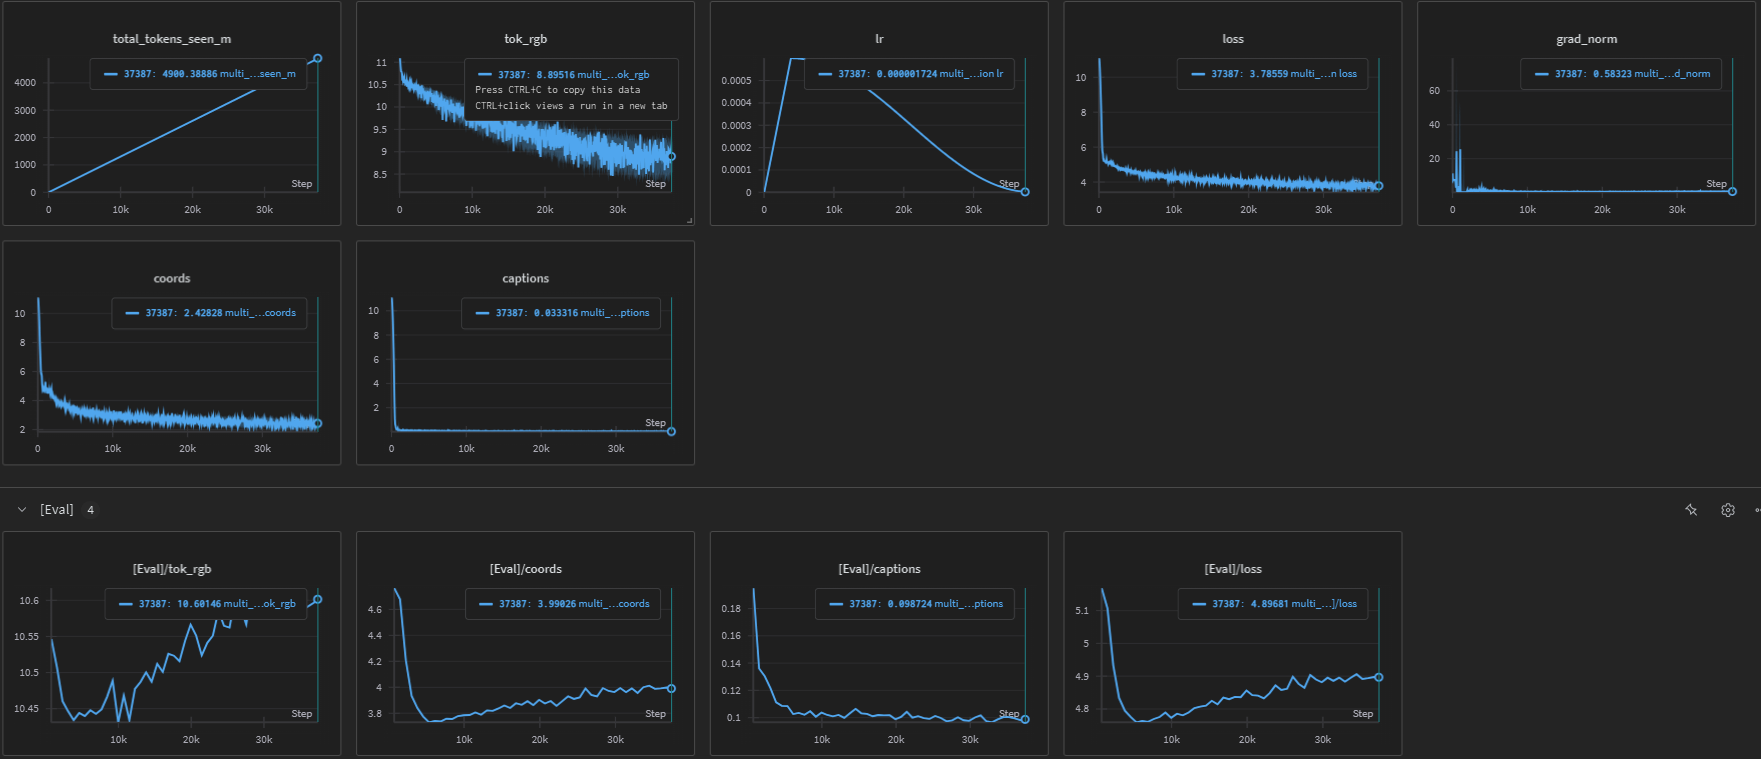

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for Cosmos tokenizer
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)
# ---------- 1. helper: tokens → PIL image --------------------
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit",
    checkpoint_dec="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit"
).to(device)

/work/com-304/new_environment/anaconda3/envs/nanofm/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
from nanofm.utils.checkpoint import load_model_from_safetensors

ckpt_path = '/home/skalli/COM-304-FM/com-304-FM-project/nano4M/outputs/nano4M/multi_penn_action/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

44.322304M parameters


# Helpers :

In [3]:
import numpy as np
def token_ids_to_image(token_ids, to_pil=False):
    """Cosmos token ids (L,) → tensor C,H,W (0-1) or PIL."""
    token_ids = token_ids.flatten()
    n = token_ids.numel()
    side = int(math.sqrt(n))
    img_toks = token_ids.reshape(1, side, side).to(device)

    with torch.no_grad():
        img = image_tokenizer.decode(img_toks)[0]          # bfloat16, GPU
    img = img.clamp(-1, 1).to(torch.float32).cpu()          # ← cast + move
    img = (img + 1) / 2                                     # 0-1

    if to_pil:
        return TF.to_pil_image(img)
    return img
def print_coords_sequence(coords: np.ndarray):
    """
    coords: either
      • shape (T, 3, 13) for T frames, or
      • shape (3, 13) for a single frame.
    Simply prints out each frame’s (x, y, vis) rows.
    """
    # Force into sequence form
    seq = coords[np.newaxis, ...] if coords.ndim == 2 else coords

    for t, frame in enumerate(seq):
        x, y, vis = frame
        print(f"(shape {frame.shape}):")
        print("  x coords:    ", x.tolist())
        print("  y coords:    ", y.tolist())
        print("  visibility:  ", vis.tolist())
        print("-" * 60)
import numpy as np
class CoordTokenizer:
    """
    Encoding scheme taken from your preprocessing script:

        • xy ∈ [0, 1]      → token 1 … 8190  (linear)
        • vis ∈ {0, 1}     → token 0 (invisible) or 8191 (visible)
        • 0 is still the global PAD

    A skeleton frame is stored as 39 tokens:
        26 xy tokens  +  13 visibility tokens
    """

    XY_MAX = 8190          # highest XY value
    VIS_TOK = 8191         # visibility = 1
    PAD_TOK = 0
    # ---------- decode  (int64 → float32) -------------------
    def decode(self, tokens: torch.Tensor) -> np.ndarray:
        """
        tokens: 1-D int tensor, length 39
        returns float32 array shape (3, 13) with xy in [0,1]
        """
        tokens = tokens.cpu().numpy()
        xy_tok, vis_tok = tokens[:26], tokens[26:]

        xy  = (np.clip(xy_tok, 1, self.XY_MAX) - 1) / (self.XY_MAX - 1)
        vis = (vis_tok == self.VIS_TOK).astype(np.float32)

        frame = np.vstack([xy.reshape(2, 13), vis.reshape(1, 13)]).astype(np.float32)
        return frame   # (3, 13)

# instantiate once
coord_tokenizer = CoordTokenizer()
skeleton_edges = [
    (1, 2), (1, 3), (2, 4), (3, 5), (4, 6),
    (7, 8), (7, 9), (8, 10), (9, 11), (10, 12)
]
from PIL import Image, ImageDraw
def construct_input_from_sample(ds, idx: int, input_modality: str):
    """Return (enc_input_tokens, enc_input_positions, enc_input_modalities)
       ready for model.forward()."""
    inp = ds[idx][input_modality]   # 1-D token tensor  (L,)
    L   = inp.shape[0]
    enc_input_tokens      = inp.unsqueeze(0).to(device)  # (1, L)
    enc_input_positions   = torch.arange(L, device=device).unsqueeze(0)  # (1, L)
    enc_input_modalities  = modalities.index(input_modality) \
                            * torch.ones(1, L, dtype=torch.long, device=device)
    return enc_input_tokens, enc_input_positions, enc_input_modalities

    return enc_input_tokens, enc_input_positions, enc_input_modalities, raw_data
def show_modality(tokens, modality, raw_data=None):
    if modality == "captions":
        print(decode_gpt2_tokens(tokens[0]))
    elif modality == "tok_rgb":
        token_ids_to_image(tokens, to_pil=True).show()
    elif modality == "coords":
        print(tokens[0])
        coords = coord_tokenizer.decode(tokens[0])
        canvas = Image.new("RGBA", (640, 640), (0, 0, 0, 255))
        draw = ImageDraw.Draw(canvas)
        visibility = coords[2]
        x,y = coords[0] * 640, coords[1] * 640
        # Joints
        for j in range(13):
            if visibility[j]:
                xj, yj = int(x[j]), int(y[j])
                if j == 0:
                    draw.ellipse((xj-5, yj-5, xj+5, yj+5), outline="red", width=2)
                else:
                    draw.ellipse((xj-3, yj-3, xj+3, yj+3), fill=(255, 0, 0, 255))
        
        # Bones
        for j1, j2 in skeleton_edges:
            if visibility[j1] and visibility[j2]:
                p1 = (int(x[j1]), int(y[j1]))
                p2 = (int(x[j2]), int(y[j2]))
                draw.line([p1, p2], fill="red", width=2)
        
        # Head to hip center
        if visibility[0] and visibility[7] and visibility[8]:
            head = (int(x[0]), int(y[0]))
            hip_center = tuple(np.mean([[x[7], y[7]], [x[8], y[8]]], axis=0).astype(int))
            draw.line([head, hip_center], fill="red", width=2)
        
        # Show
        plt.imshow(canvas)
        plt.axis("off")
        plt.title("Pose from .mat + frame")
        plt.show()
    else:
        raise ValueError(f"Unknown modality: {modality}")
from transformers import GPT2TokenizerFast

gpt2_tok = GPT2TokenizerFast.from_pretrained("gpt2", padding_side="right")
gpt2_tok.pad_token = gpt2_tok.eos_token          # to match your encoding step
# --------------------------------------------------------------------
# 2.  Safe decode helper
# --------------------------------------------------------------------
def decode_gpt2_tokens(tokens: torch.Tensor) -> str:
    """
    tokens: 1-D or 2-D LongTensor that may include padding (pad_token_id) or
            your loss ignore index (-100).  Returns a Python str.
    """
    # flatten & move to CPU, turn into py list of ints
    ids = tokens.detach().cpu().view(-1).tolist()

    # drop special/invalid ids (pad_token_id or -100)
    valid_ids = [t for t in ids if t >= 0 and t != gpt2_tok.pad_token_id]

    # GPT-2 decode
    return gpt2_tok.decode(valid_ids, skip_special_tokens=True).strip()

In [4]:
modalities= ["tok_rgb", "captions", "coords"]
from nanofm.data.multimodal.penn_action_multimodal_dataset import (
    PennActionMultimodalDataset
)
dataset = PennActionMultimodalDataset(
    root_dir = "/work/com-304/CFT/output/",
    split    = "train",
    modalities = modalities,
    sample_from_k_augmentations = 1,
    text_tokenizer_path = "gpt2",
    text_max_length     = 256,
    transforms          = None,
)

### tok_rgb -> coords -> captions

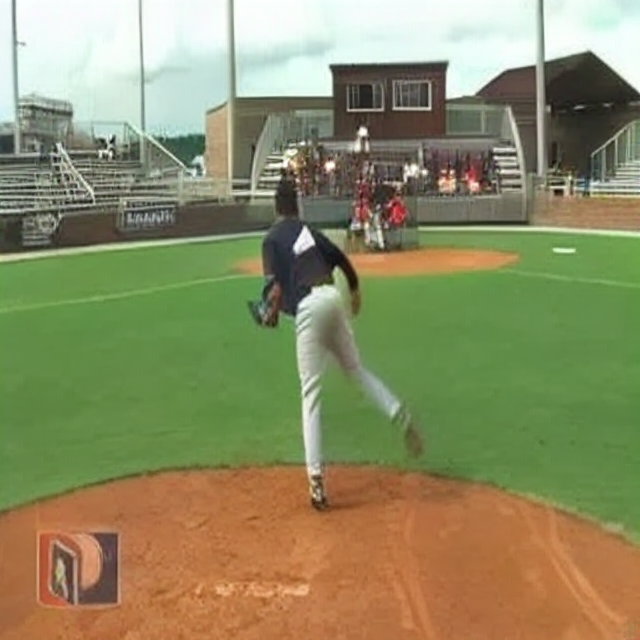

tensor([3622, 3980, 4415, 4453, 3570, 4543, 4261, 4057, 3826, 4249, 4018, 4325,
        4044, 2065, 2662, 2645, 3396, 3191, 3788, 2969, 4419, 3907, 5255, 5272,
        7285, 6159, 8191, 8191,    0, 8191,    0,    0,    0, 8191, 8191, 8191,
        8191, 8191, 8191], device='cuda:0')


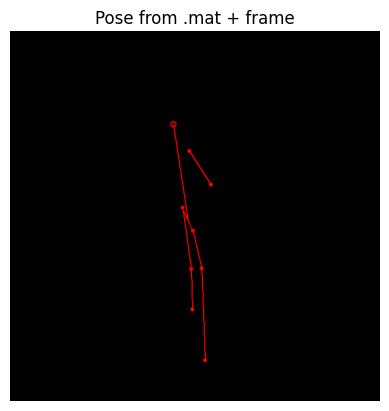

a baseball player pitching a ball on the field


In [34]:
input_modality = 'tok_rgb'
sample_idx = 2000

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'coords'
num_steps, temp, top_p, top_k = 6, 0.0001, 0.0, 10

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

target_mod = 'captions'
num_steps, temp, top_p, top_k = 6, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

## tok_rgb -> captions

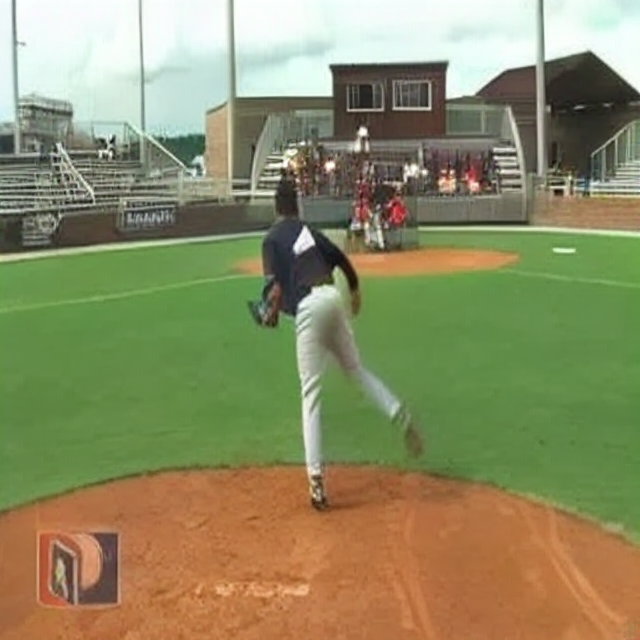

a baseball player pitching standing ball on the field


In [6]:
input_modality = 'tok_rgb'
sample_idx = 2000

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'captions'
num_steps, temp, top_p, top_k = 6, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)


tensor([3635, 3980, 3456, 4390, 3520, 4543, 3469, 4326, 3827, 4543, 3980, 5106,
        4044, 2526, 2918, 2952, 3396, 3720, 3891, 4078, 3908, 3993, 4880, 5170,
        5273, 6160, 8191,    0, 8191, 8191, 8191, 8191, 8191,    0, 8191, 8191,
        8191, 8191, 8191], device='cuda:0')


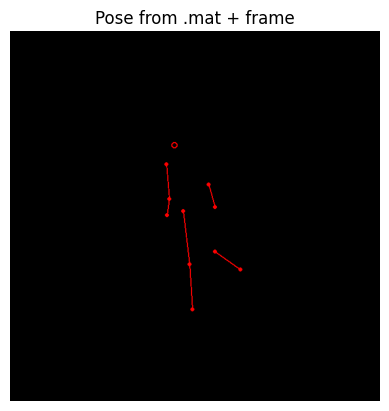

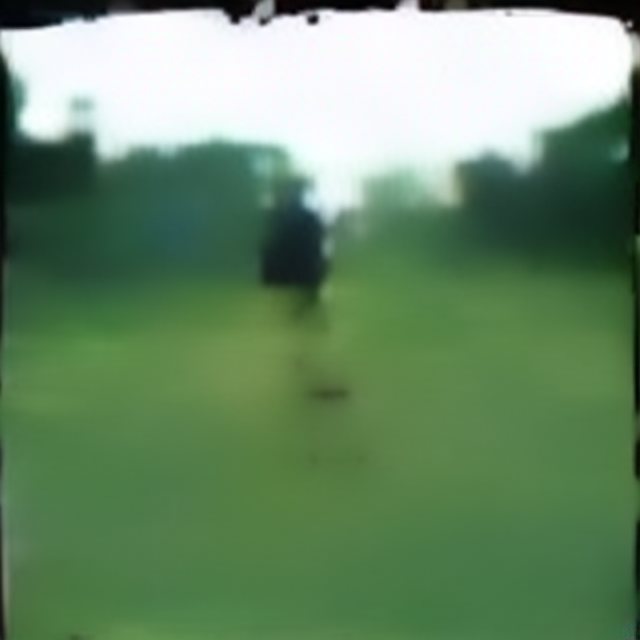

In [31]:
input_modality = 'coords'
sample_idx = 2000

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'tok_rgb'
num_steps, temp, top_p, top_k = 100, 0.7, 0.9, 10

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

tensor([2240, 2291, 1754, 2726, 2407, 2752, 2637, 1984, 1831, 2419, 1741, 2381,
        1588, 1519, 2321, 2236, 3362, 3379, 2662, 2782, 3857, 4078, 5784, 5802,
        7371, 7286, 8191, 8191,    0, 8191,    0, 8191,    0, 8191,    0, 8191,
        8191, 8191, 8191], device='cuda:0')


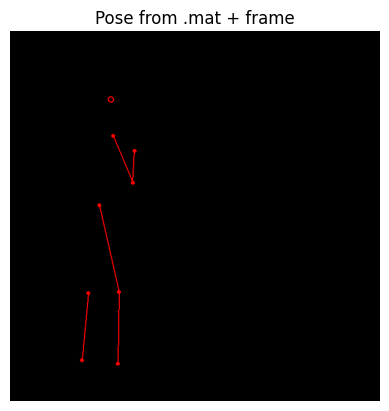

a man swinging playing golf on the a


In [21]:
input_modality = 'coords'
sample_idx = 1

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'captions'
num_steps, temp, top_p, top_k = 3, 0.7, 0.0, 0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)